In [1]:
# Author: Ehud Behar
# All macros in one def keyword
import os
import glob 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [50]:
# This function takes all the csv files from a group of measurement (control, stage 1, stage 2 or stage3) and appends all the "Intensity" columns to one table.
def append_columns(directory):
    os.chdir(os.path.join(r"C:\Users\ehud\Documents\bell-pepper\2025-04-0609", directory)) # Set the current working directory
    print("Working directory is\n", os.getcwd())
    csv_files=glob.glob("*.csv")  # Find all .csv files in the current working directory
    # from each csv file in the current working directory, read only the "Intensity" column and concatenate all columns to one dataframe, which we shall call `dataset`:
    dataset=pd.concat(
        [
            pd.read_csv(file, usecols=["Intensity"]).rename(
                columns={"Intensity": os.path.splitext(file)[0]}
            )
            for file in csv_files
        ],
        axis=1
    )
    # prepend to this dataframe the wavelength column and reset the result. The wv column is taken from one of the csv files that has already been read to the above dataframe.
    # All wv columns in this directory should be identical; For convenience we take the column from the first file.

    # Read the Wavelength column from the first csv file
    wavelength = pd.read_csv(csv_files[0], usecols=["Wavelength"])

    dataset=pd.concat([pd.read_csv(csv_files[0], usecols=["Wavelength"]).rename(columns={"Wavelength":"wv"}), dataset], axis=1)
    return dataset

In [51]:
# This function creates a new dataframe with the value of numerical integral of spectral intensity vs. wavelength, for each column:
def numeric_integrals(dataset):
    # 
    results = {}

    for col in range(dataset.shape[1] - 1):
        col_name = dataset.columns[col + 1]
        integral = np.trapezoid(dataset.iloc[:, col + 1], dataset['wv'])
        results[col_name] = integral
    # Convert the results to a DataFrame if needed
    integrals = pd.DataFrame([results])
    del results
    del col_name
    del integral
    return integrals

In [59]:
control_integrals=numeric_integrals(append_columns("control"))
st1_integrals=numeric_integrals(append_columns("stage1"))
st2_integrals=numeric_integrals(append_columns("stage2"))
st3_integrals=numeric_integrals(append_columns("stage3"))

Working directory is
 C:\Users\ehud\Documents\bell-pepper\2025-04-0609\control
Working directory is
 C:\Users\ehud\Documents\bell-pepper\2025-04-0609\stage1
Working directory is
 C:\Users\ehud\Documents\bell-pepper\2025-04-0609\stage2
Working directory is
 C:\Users\ehud\Documents\bell-pepper\2025-04-0609\stage3


In [ ]:
# Create a dictionary of exposure times for each group
dt={}
for sheet_name in pd.ExcelFile(r"..\correspondence_exposure_times.xlsx").sheet_names:
    dt[sheet_name]=pd.read_excel(
        r"..\correspondence_exposure_times.xlsx",
        sheet_name=sheet_name,
        dtype={"file name": str}  # Specify the column to be read as string
    ).iloc[:, -1:] # import only the last two columns in the excel sheet

# Combine the dictionary of DataFrames into a single DataFrame for display
deltat = pd.concat(dt) ; del dt

In [ ]:
# Divide the exposure time by the power integral, for each group
power={}
power["control"] = st2_integrals.loc[0] / deltat.loc["control"].values.flatten()
power["stage1"] = st1_integrals.loc[0] / deltat.loc["stage1"].values.flatten()
power["stage2"] = st2_integrals.loc[0] / deltat.loc["stage2"].values.flatten()
power["stage3"] = st2_integrals.loc[0] / deltat.loc["stage3"].values.flatten()

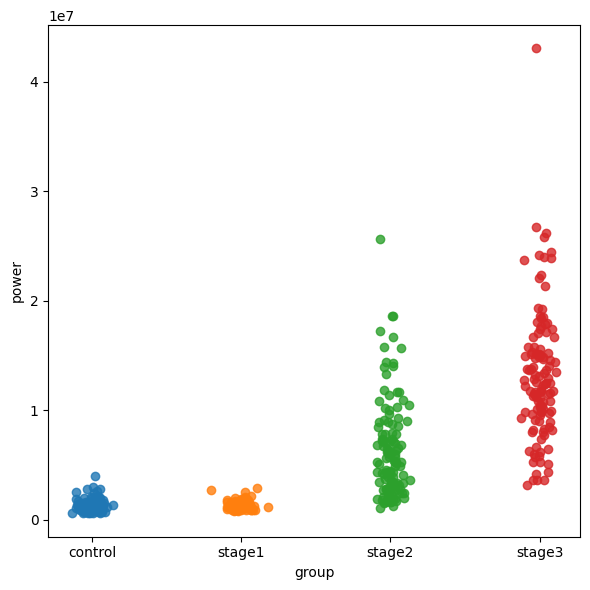

In [80]:
categories = list(power.keys())
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

plt.figure(figsize=(6, 6))
for i, (category, y_values) in enumerate(power.items()):
    x_jitter = np.random.normal(loc=i, scale=0.05, size=len(y_values))
    plt.scatter(x_jitter, y_values, alpha=0.8, color=colors[i])
plt.xticks(range(len(categories)), categories)
plt.xlabel("group")
plt.ylabel("power")
plt.tight_layout()
plt.show()

     control  stage1  stage2  stage3
0        7.0     5.5     3.0    1.20
1        5.5     7.0     3.0    0.85
2        5.5     8.5     5.0    0.70
3        3.5     7.5     2.5    0.60
4        5.0     7.0     2.0    0.60
..       ...     ...     ...     ...
115      2.8     7.0     4.0    0.35
116      5.5     9.0     1.1    0.65
117     10.0     5.5     1.0    0.55
118      1.7     9.0     1.1    0.45
119      5.0     9.0     1.6    1.50

[120 rows x 4 columns]


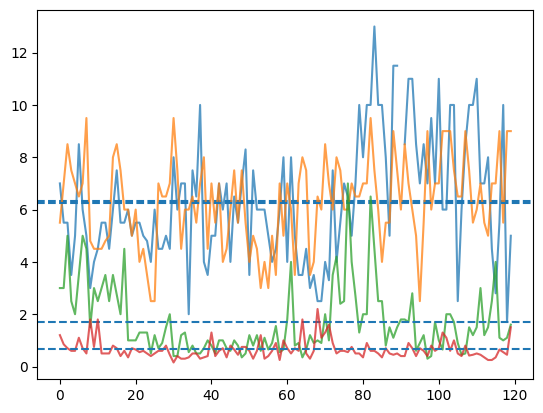

In [ ]:
# Plot the distribution of exposure times

last_cols = []

for sheet in ['control', 'stage1', 'stage2', 'stage3']:
    # Read only the last column of the sheet
    df = pd.read_excel(r"C:\Users\ehud\Documents\bell-pepper\2025-04-0609\correspondence_exposure_times.xlsx", sheet_name=sheet)
    
    # Select the last column (using iloc)
    last_col = df.iloc[:, -1]
    
    # Rename the series to the sheet name (to keep track after combining)
    last_col.name = sheet
    
    last_cols.append(last_col)

# Combine all expsure times columns into a single DataFrame (by aligning indices)
exposure_times = pd.concat(last_cols, axis=1)
print(exposure_times)

for col in exposure_times.columns:
    plt.plot(exposure_times[col], label=col,alpha=0.75)
    plt.axhline(np.nanmean(exposure_times[col]), linestyle='--')